# Dataset Preparation


In [16]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter


def load_images_and_labels(image_dir, label_dir, image_size=(128, 128)):
    images = [] 
    labels = []

    #go through the image files in the folder
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpeg'):
            #make the path for the image and that images label
            img_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, filename.replace('.jpeg', '.txt'))

            # Load and resize image 
            img = imread(img_path) 
            #images might come in many sizes, making them consitent makes feature extraction easier 
            #also normalises to help in our model development
            img_resized = resize(img, image_size, anti_aliasing=True) 
            images.append(img_resized)  # add to the list 

            # Read label
            with open(label_path, 'r') as f:
                label = int(f.read().strip()) #read the label and convert it to an interger
            labels.append(label) # add to the list 

    #converts the two lists, image and label into numpy arrays 
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64)

def plot_class_distribution(labels, title):
    counter = Counter(labels)
    classes = sorted(counter.keys())
    counts = [counter[c] for c in classes]
    plt.figure(figsize=(6, 4))
    plt.bar(classes, counts, tick_label=[f"Class {c}" for c in classes])
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
def prepare_datasets(
    train_image_path, train_label_path,
    test_image_path, test_label_path,
    image_size=(128, 128),
    val_split=0.2,
    seed=42
):
    # Load the whole training set both labels and images, they are resized and normalised 
    X_train_full, y_train_full = load_images_and_labels(train_image_path, train_label_path, image_size)
    
    #same with the test set 
    X_test, y_test = load_images_and_labels(test_image_path, test_label_path, image_size)


    # Show distribution before split
    plot_class_distribution(y_train_full, "Train Full Distribution")
    plot_class_distribution(y_test, "Test Distribution")

    # Split training data into train validation, standard split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_split, random_state=seed, stratify=y_train_full #ensure smae label distribution with stratify
    )

    # Show distribution after split
    plot_class_distribution(y_train, "Train Split Distribution")
    plot_class_distribution(y_val, "Validation Split Distribution")

    #sanity check
    print(f"Train: {X_train.shape}, {y_train.shape}")
    print(f"Validation: {X_val.shape}, {y_val.shape}")
    print(f"Test: {X_test.shape}, {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

load training and test data, resize, normalise, split the data into the sets, and returns as numpy


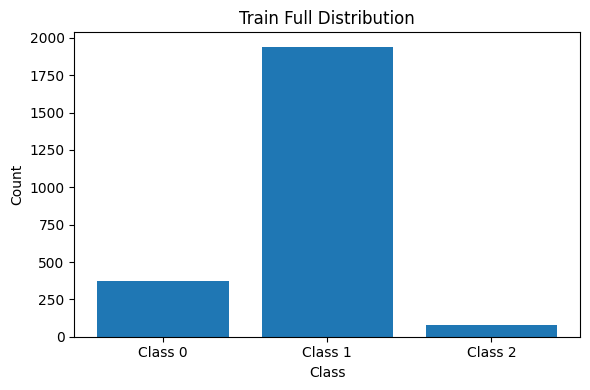

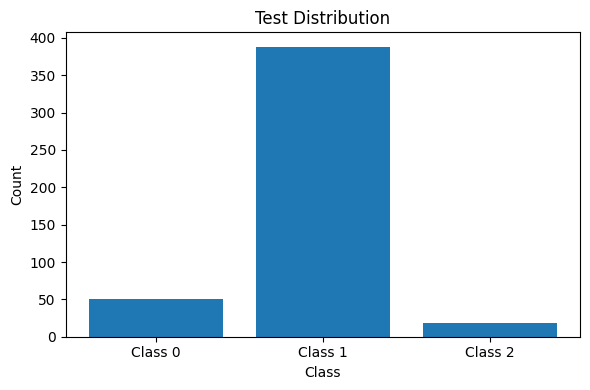

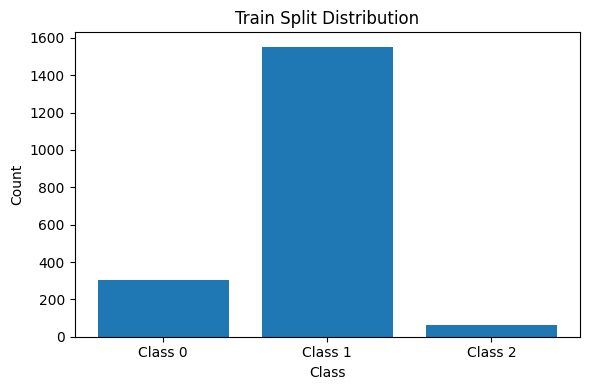

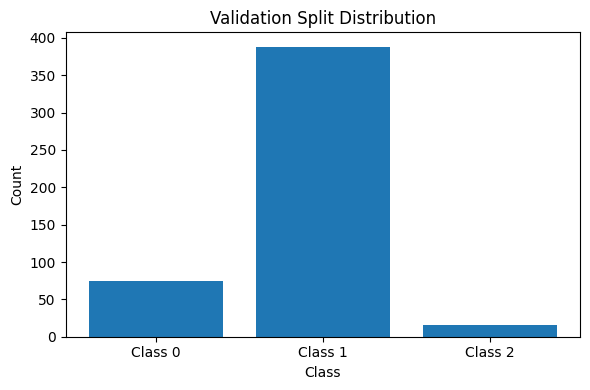

Train: (1915, 128, 128, 3), (1915,)
Validation: (479, 128, 128, 3), (479,)
Test: (458, 128, 128, 3), (458,)


In [17]:
import os

#dataset base path using relative path
BASE_DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(),'..', 'CW_Dataset'))

train_image_path = os.path.join(BASE_DATASET_PATH, 'train', 'images')
train_label_path = os.path.join(BASE_DATASET_PATH, 'train', 'labels')
test_image_path = os.path.join(BASE_DATASET_PATH, 'test', 'images')
test_label_path = os.path.join(BASE_DATASET_PATH, 'test', 'labels')

X_train, y_train, X_val, y_val, X_test, y_test = prepare_datasets(
    train_image_path, train_label_path,
    test_image_path, test_label_path,
    image_size=(128, 128)
)

# class encompassing all of the evaluation metrics i will use


In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

class ModelEvaluator:
    def __init__(self, class_names=["No Mask", "Mask", "Incorrect"]):
        # instead of having the 0,1,2 labels usd actual descriptors for clarity 
        self.class_names = class_names

    def evaluate(self, y_true, y_pred, model_name="Model", verbose=True):
      
        results = {}

        # accuracy score 
        acc = accuracy_score(y_true, y_pred)
        results['accuracy'] = acc

        # Macro = equally weighs all classes (sensitive to minority classes)
        results['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        results['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        results['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # Micro = globally computed over all samples for class imbalance)
        results['precision_micro'] = precision_score(y_true, y_pred, average='micro', zero_division=0)
        results['recall_micro'] = recall_score(y_true, y_pred, average='micro', zero_division=0)
        results['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)

        # Weighted = like macro but adjusts for class imbalance by using class frequencies
        results['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        if verbose:
            print(f"\nEvaluation results for {model_name}:")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score (macro): {results['f1_macro']:.4f}")
            print(f"F1 Score (weighted): {results['f1_weighted']:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

        return results

    def plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix"):
        #plot a confusion matrix 

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def visualize_predictions(self, images, y_true, y_pred, n_samples=4):
        
        #Display somerandom image samples with ground truth and predicted labels, this will be useful for examples if i use them in the report
        indices = random.sample(range(len(images)), n_samples)
        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(indices):
            img = images[idx]
            true_label = self.class_names[y_true[idx]]
            pred_label = self.class_names[y_pred[idx]]
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.tight_layout()
        plt.show()
#initialise evaluator
evaluator = ModelEvaluator(class_names=["No Mask", "Mask", "Incorrect"])

## why i chose each of the metrics:



### macro 
shows how the model works on all classes equally
### micro 
a more broad perspective, this is good for if there is an imbalance
### weighted
 is the middle ground balancing macro with the proportions of the classes 

### Accuracy


Overall correctness of the model so kind of essential
kind of limited if classes are imbalanced 

### Precision 

measure for how many predicted positives were actually correct

### Recall

measure how many ACTUAL postives were caught 

### F1 score 

combination of precision and recall, better for imbalanced classes and good to check robustness

### classification report

joined breakeddown of the previous metrics, good to find underperforming class

### Confusion matrix

visualsing the results so that we can see where the model confused things like incorrectly worn mask  with no mask at all

### visualise predictions

will help with examples in the report 

# Models

##  HOG + SVM 

In [19]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from evaluator import ModelEvaluator
import numpy as np
import joblib
import os

# Path to save the model relative to the current script
MODEL_SAVE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'Models', 'hog_svm_model.joblib'))
MODEL_SAVE_PATH = os.path.abspath(MODEL_SAVE_PATH)


# extracting HOG Features 
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for img in images:
        # Convert to grayscale for HOG
        gray_img = np.mean(img, axis=2) #convert to grayscale
        #calc HOG descriptor for the image 
        features = hog(
            gray_img,
            orientations=orientations, #number of orientation bins 
            pixels_per_cell=pixels_per_cell, #size of the cell
            cells_per_block=cells_per_block, #group for local contrast
            block_norm='L2-Hys', #method for normalization
            feature_vector=True #make sure we output a flat vector 
        )
        #store the descriptor
        hog_features.append(features) 
    return np.array(hog_features) #2d array, each row is a HOG feature

# training
def train_hog_svm(X_train, y_train):
    print("Extracting HOG features for training...")
    hog_train = extract_hog_features(X_train)

    print("Training SVM classifier...")
    #rbf kernel handles non linear decision boundaries 
    clf = SVC(kernel='rbf', C=10, gamma=0.01)
    clf.fit(hog_train, y_train)

    # Save model to the defined path
    joblib.dump(clf, MODEL_SAVE_PATH)
    print(f"Model saved to: {MODEL_SAVE_PATH}")

    return clf #the trained model

# evaluate the svm 
def evaluate_hog_svm(clf, X, y, split_name="Validation"):
    #using the validation set for now so we can see how it performs on unseen data
    print(f"\n Extracting HOG features for {split_name} set...")
    hog_features = extract_hog_features(X)

    print(f"Predicting {split_name} set...")
    y_pred = clf.predict(hog_features)

    # Use evaluator to get and print detailed metrics
    evaluator.evaluate(y, y_pred, model_name=f"HOG + SVM ({split_name})")
    evaluator.plot_confusion_matrix(y, y_pred, title=f"HOG + SVM - {split_name} Confusion Matrix")

    return y_pred #the labels our model predicted

# visualise some results which were predicted
def show_predictions(X, y_true, y_pred, n_samples=4):
    evaluator.visualize_predictions(X, y_true, y_pred, n_samples=n_samples)


### now lets run it 

Extracting HOG features for training...
Training SVM classifier...
Model saved to: /Users/david/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents – David’s MacBook Pro/university/year 3/Computer vision/cw/maskDetection/Models/hog_svm_model.joblib

 Extracting HOG features for Validation set...
Predicting Validation set...

Evaluation results for HOG + SVM (Validation):
Accuracy: 0.8622
F1 Score (macro): 0.5194
F1 Score (weighted): 0.8319

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.85      0.37      0.52        75
        Mask       0.86      0.99      0.92       388
   Incorrect       1.00      0.06      0.12        16

    accuracy                           0.86       479
   macro avg       0.90      0.48      0.52       479
weighted avg       0.87      0.86      0.83       479



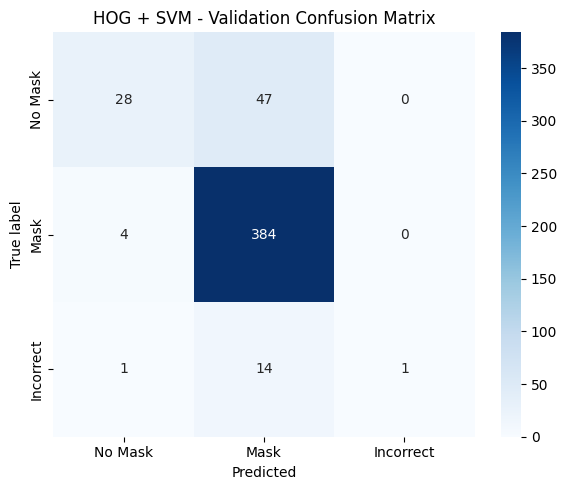

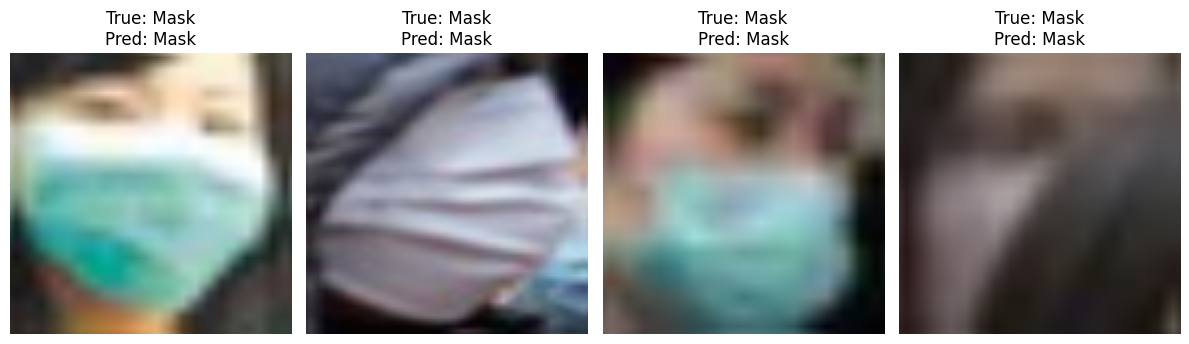

In [20]:

# train on training set
hog_svm_model = train_hog_svm(X_train, y_train)

# Evaluate only on validation set
val_preds = evaluate_hog_svm(hog_svm_model, X_val, y_val)

# Visualize some results from validation set
show_predictions(X_val, y_val, val_preds)

## SIFT + BoVW + MLP

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from evaluator import ModelEvaluator
import os
import joblib

# Set project-relative path
PROJECT_DIR = os.getcwd()
MODEL_DIR = os.path.join(PROJECT_DIR, '..', 'Models')
#os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, 'sift_mlp_model.joblib')
KMEANS_PATH = os.path.join(MODEL_DIR, 'sift_kmeans.joblib')
evaluator = ModelEvaluator(class_names=["No Mask", "Mask", "Incorrect"])
def extract_sift_descriptors(images, max_features_per_image=100):
   
    sift = cv2.SIFT_create() #feature extracture, takes keypoints and descriptors 
    descriptors_list = []
    valid_indices = []

    for idx, img in enumerate(tqdm(images, desc="Extracting SIFT descriptors")):
        #converting the previously normalised float back to 8-bit with unit8 for OpenCV
        gray = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY) #convert to grayscale 
        _, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is not None:
            #limit descriptors to contorl computational time
            descriptors_list.append(descriptors[:max_features_per_image]) 
            valid_indices.append(idx)  # record that image worked

    return descriptors_list, valid_indices #return descriptors and indices that worked 

def build_visual_vocabulary(descriptor_list, vocab_size=100):
    all_descriptors = np.vstack(descriptor_list) #all the descriptors from the images into a single array

    #using kMeans group descriptors inot clusters
    kmeans = MiniBatchKMeans(
        n_clusters=vocab_size, #numb of visual words
        batch_size=1000, #batch size, 1000 is a balance between fast and scalable
        random_state=42#reproducibility seed 
        ) 
    kmeans.fit(all_descriptors)#fit the model to all the descriptors 
    return kmeans #returning the trained vocab model

def compute_bovw_histograms(descriptor_list, kmeans_model):
    vocab_size = kmeans_model.n_clusters #number of bins in the bag of visual words histogram
    histograms = []

    for descriptors in descriptor_list:
        histogram = np.zeros(vocab_size) #initialise histogram with zero
        if descriptors is not None:
            words = kmeans_model.predict(descriptors) #each descriptor is assigned to a visual word
            for w in words:
                histogram[w] += 1 #increment the count in corresponding histogram bin
        histograms.append(histogram) # add the histogram to the list

    return np.array(histograms) #list into array

def train_sift_mlp(X_train, y_train, vocab_size=100):
    print("Extracting SIFT features...")
    #retrieve the usable descriptors and indicies
    descriptors_list, valid_indices = extract_sift_descriptors(X_train)

    #filter the labels corresponding to valid images
    y_train_filtered = y_train[valid_indices]

    print("Building visual vocabulary...")
    kmeans_model = build_visual_vocabulary(descriptors_list, vocab_size=vocab_size)

    #features converted to fixed length histograms
    print("Building BoVW histograms...")
    bovw_train = compute_bovw_histograms(descriptors_list, kmeans_model)

    print("Training MLP classifier...")
    clf = MLPClassifier(
        hidden_layer_sizes=(128,),#one hidden layer with 128 neuronr
        max_iter=500, # 500 training iterations
        random_state=42 #for reproducibility
        )
    clf.fit(bovw_train, y_train_filtered) #training the MLP on BoVW features and label
    # Save models
    joblib.dump(clf, MODEL_PATH)
    joblib.dump(kmeans_model, KMEANS_PATH)

    return clf, kmeans_model  # return both for reuse on evaluation

def evaluate_sift_mlp(clf, kmeans_model, X_val, y_val):
    descriptors_val, val_indices = extract_sift_descriptors(X_val) #extract descriptors from the validation set
    y_val_filtered = y_val[val_indices] #filter out the labels for usable validation images

    bovw_val = compute_bovw_histograms(descriptors_val, kmeans_model) #convert the data in the validation files to BoVW vectors
    y_pred = clf.predict(bovw_val) #predict

    evaluator.evaluate(y_val_filtered, y_pred, model_name="SIFT + BoVW + MLP") 
    evaluator.plot_confusion_matrix(y_val_filtered, y_pred, title="SIFT + BoVW + MLP - Validation Confusion Matrix")

    return y_pred

def show_predictions(X_val, y_val, y_pred, n_samples=4):
    #visualise some examples
    evaluator.visualize_predictions(X_val, y_val, y_pred, n_samples=n_samples)

Extracting SIFT features...


Extracting SIFT descriptors: 100%|██████████| 1915/1915 [00:04<00:00, 422.59it/s]


Building visual vocabulary...
Building BoVW histograms...
Training MLP classifier...


Extracting SIFT descriptors: 100%|██████████| 479/479 [00:01<00:00, 409.12it/s]



Evaluation results for SIFT + BoVW + MLP:
Accuracy: 0.8121
F1 Score (macro): 0.4496
F1 Score (weighted): 0.7924

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.52      0.41      0.46        75
        Mask       0.86      0.92      0.89       388
   Incorrect       0.00      0.00      0.00        16

    accuracy                           0.81       479
   macro avg       0.46      0.45      0.45       479
weighted avg       0.78      0.81      0.79       479



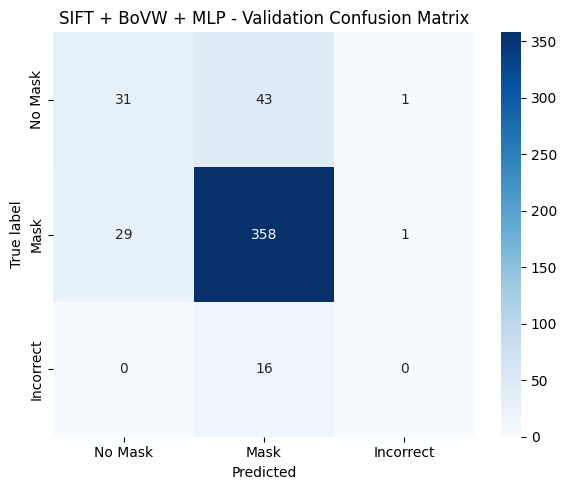

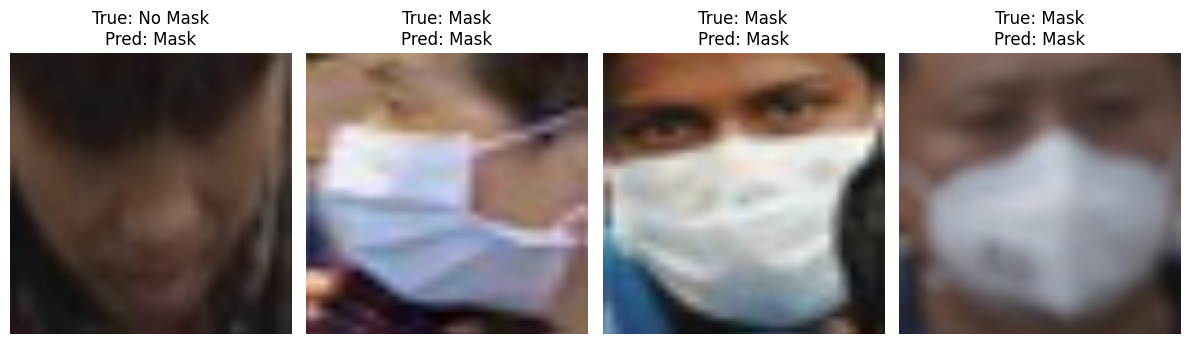

In [26]:

# Train SIFT + BoVW + MLP
sift_mlp_model, sift_kmeans = train_sift_mlp(X_train, y_train, vocab_size=100)

# Evaluate on validation set
val_preds_sift = evaluate_sift_mlp(sift_mlp_model, sift_kmeans, X_val, y_val)

# Visualize
show_predictions(X_val, y_val, val_preds_sift)

## First CNN

In [ ]:
import tensorflow as tf
from keras.api.models import Sequential, load_model
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.api.utils import to_categorical
from keras.api.callbacks import EarlyStopping
from keras.api.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import joblib
import numpy as np, random, tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


# Get current working directory
NOTEBOOK_DIR = os.getcwd()

# Go up one level to reach the project root from /Code
PROJECT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))

# Path to the outermost 'Models' folder
MODEL_SAVE_PATH = os.path.join(PROJECT_DIR, 'Models')

# Create directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

def build_cnn(input_shape=(128, 128, 3), num_classes=3, filters=(32, 64, 128), dense_units=128, dropout=0.5):
    model = Sequential() #using a sequential model
    model.add(Input(shape=input_shape)) #defining the input shape (it's 128 by 128 RBG img)

    # mulitple conv to max pooling to dropout blocks 
    for i, f in enumerate(filters):
        model.add(Conv2D(f, (3, 3), activation='relu', padding='same')) #layers where features are detected
        model.add(MaxPooling2D(pool_size=(2, 2)))  #reduces spatial dimensions by 2x, makes feature map smaller and more abstract
        #randomly drop .2 then .3 then .4... neurons in training, the more the deeper the layers
        model.add(Dropout(0.2 + i * 0.1))#dropout increases with layers to prevenet overfitting and help with regularization

    model.add(Flatten())# Flatten ouutputs of previous layers to 1D 
    model.add(Dense(dense_units, activation='relu')) # Fully connected layer, relu helps the network learn non linear boundaries 
    model.add(Dropout(dropout)) #stronger regularization to prevent overfitting before output layer
    model.add(Dense(num_classes, activation='softmax')) # final output layer has a neuron ofr each class, softmax converts scores to class probs

    return model

#compiles model with an optimizer and a loss function
def compile_model(model, lr):
    model.compile(
        optimizer=Adam(learning_rate=lr),  #adaptive learning rate optimizer
        loss='categorical_crossentropy',#good for mulit class classification
        metrics=['accuracy']#keep track during training and evaluation
    )
    return model

#the class where we train, eval, and tune the cnn
class CNNTrainer:
    #call the training of a model with the best parameters we found
    def train_best_model(self, X_train, y_train, X_val, y_val):
        #input_shape = X_train.shape[1:] allows the model to be flexible to different resolutions 
          
        model_path = os.path.join(MODEL_SAVE_PATH, 'best_model_gridsearch.keras')
        model = load_model(model_path)  # Load the best model found from grid search
        print("Loaded model parameters:")
        print(model.get_config())
        
        # #  # Define fixed best hyperparameters
        # # filters = (64, 128, 256)
        # # dense_units = 128
        # # dropout = 0.3
        # # lr = 0.001
        # # batch_size = 32
        # # epochs = 15

        # # Build and compile model with those params
        # model = build_cnn(input_shape=X_train.shape[1:], num_classes=3,
        #                 filters=filters, dense_units=dense_units, dropout=dropout)
        # model = compile_model(model, lr)

        # print("Using manually selected best config:")
        # print((filters, dense_units, dropout, lr, batch_size, epochs))
        # print(model.get_config())

        # Convert labels to categorical (1 -> [0, 1, 0])
        y_train_cat = to_categorical(y_train, num_classes=3)
        y_val_cat = to_categorical(y_val, num_classes=3)
        
        #to handle the imbalances in the dataset im using the class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {i: class_weights[i] for i in range(3)}

        #prevent overfitting in accordance to validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        #now we train the model
        model.fit(X_train, y_train_cat,
                  validation_data=(X_val, y_val_cat),
                  epochs=20,
                  batch_size=32,
                  class_weight=class_weights_dict, #prevent bias to majority class like correct
                  callbacks=[early_stop],
                  verbose=1)
        #save the model for reuse
        # Using model.save() for CNN as it's a Keras model (saves full model + weights)
        # joblib is used for simpler models like SVM/MLP that don't need architecture saved   
        model.save(os.path.join(MODEL_SAVE_PATH, 'best_CNN_model.keras'))
        return model

#testing hyperparameter combinations to find the best ones
#i went for a manual gridsearch to have full control over the specificic combinations
#as the classes are imbalanced f1 score is the best to determine the models performance
    def run_grid_search(self, X_train, y_train, X_val, y_val, param_grid):
        best_f1 = -1 #track the best f1 score
        best_model = None
        best_config = None

        #loop through the parameter grid to check which combination is the best perfoming
        for filters, dense_units, dropout, lr, batch_size, epochs in param_grid:
            print(f"\n\U0001F50D Training model with filters={filters}, dense_units={dense_units}, "
                  f"dropout={dropout}, lr={lr}, batch_size={batch_size}, epochs={epochs}")

            #build model with a flexible input in case of different resolution
            model = build_cnn(input_shape=X_train.shape[1:], num_classes=3,
                              filters=filters, dense_units=dense_units, dropout=dropout)
            #compile 
            model = compile_model(model, lr)

            y_train_cat = to_categorical(y_train, num_classes=3)
            y_val_cat = to_categorical(y_val, num_classes=3)

            class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
            class_weights_dict = dict(enumerate(class_weights))

            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

            model.fit(X_train, y_train_cat,
                      validation_data=(X_val, y_val_cat),
                      epochs=epochs,
                      batch_size=batch_size,
                      class_weight=class_weights_dict,
                      callbacks=[early_stop],
                      verbose=1)

            y_pred = np.argmax(model.predict(X_val), axis=1) #convert the softmax output, to the class labels
            results = evaluator.evaluate(y_val, y_pred, model_name=f"GridCNN {filters}-{dense_units}-{dropout}")
            evaluator.plot_confusion_matrix(y_val, y_pred) #plot the confusion matrix

            if results['f1_macro'] > best_f1: #using marco f1 puts a foucs on the perfomance across all classes
                best_f1 = results['f1_macro']
                best_model = model
                best_config = (filters, dense_units, dropout, lr, batch_size, epochs)

        print(f"\n\U0001F3C6 Best Configuration: {best_config}, Macro F1: {best_f1:.4f}")
        # Using model.save() for CNN as it's a Keras model (saves full model + weights)
        # joblib is used for simpler models like SVM/MLP that don't need architecture saved
        best_model.save(os.path.join(MODEL_SAVE_PATH, 'best_gridsearch_model.keras'))
        return best_model, best_config

    #evalute the final model with the metrics and confusion matrix from the evaluator class
    def evaluate_model(self, model, X_val, y_val):
        y_pred = np.argmax(model.predict(X_val), axis=1)
        evaluator.evaluate(y_val, y_pred, model_name="Final Model")
        evaluator.plot_confusion_matrix(y_val, y_pred)
        return y_pred

    #visualise some results for the report
    def visualize_predictions(self, model, X_val, y_val, n_samples=4):
        y_pred = np.argmax(model.predict(X_val), axis=1)
        evaluator.visualize_predictions(X_val, y_val, y_pred, n_samples=n_samples)



🔍 Training model with filters=(32, 64, 128), dense_units=128, dropout=0.3, lr=0.001, batch_size=32, epochs=15
Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5197 - loss: 1.3493 - val_accuracy: 0.8518 - val_loss: 0.3718
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4887 - loss: 1.0312 - val_accuracy: 0.9144 - val_loss: 0.2834
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.7419 - loss: 0.6304 - val_accuracy: 0.9061 - val_loss: 0.3822
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.8106 - loss: 0.5592 - val_accuracy: 0.9228 - val_loss: 0.2554
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.7393 - loss: 0.7025 - val_accuracy: 0.8956 - val_loss: 0.3184
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8300 - loss: 0.4494 - val_accuracy: 0.9269 - val_loss: 0.3006
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.8544 - loss: 0.4040 - val_accuracy: 0.8768 - val_loss

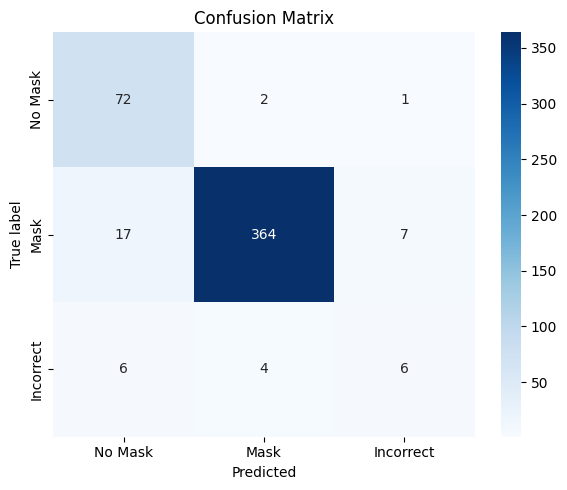


🔍 Training model with filters=(32, 64, 128, 256), dense_units=128, dropout=0.3, lr=0.0001, batch_size=32, epochs=15
Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.5505 - loss: 1.1311 - val_accuracy: 0.6681 - val_loss: 1.0574
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.7045 - loss: 0.9268 - val_accuracy: 0.8539 - val_loss: 0.6998
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7441 - loss: 0.7482 - val_accuracy: 0.8622 - val_loss: 0.5430
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.7342 - loss: 0.6797 - val_accuracy: 0.8706 - val_loss: 0.5150
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.8155 - loss: 0.4990 - val_accuracy: 0.8747 - val_loss: 0.4748
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.8201 - loss: 0.4984 - val_accuracy: 0.8935 - val_loss: 0.4324
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.8066 - loss: 0.4718 - val_accuracy: 0.8914

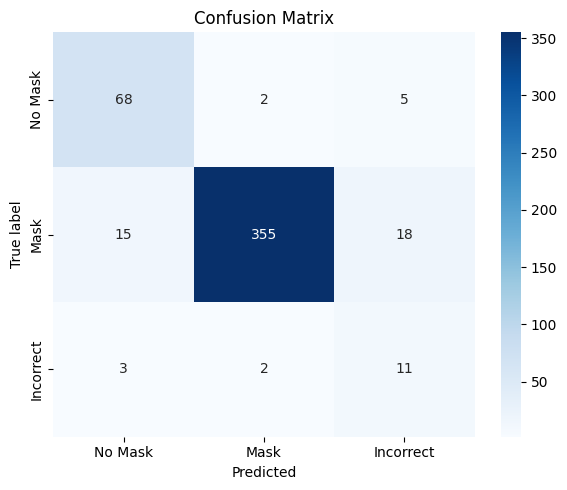


🔍 Training model with filters=(64, 128, 256), dense_units=256, dropout=0.2, lr=0.001, batch_size=64, epochs=20
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 785ms/step - accuracy: 0.1893 - loss: 2.9568 - val_accuracy: 0.2213 - val_loss: 1.0982
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 808ms/step - accuracy: 0.5392 - loss: 0.9396 - val_accuracy: 0.9123 - val_loss: 0.3410
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 779ms/step - accuracy: 0.8280 - loss: 0.7952 - val_accuracy: 0.7808 - val_loss: 0.8136
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 829ms/step - accuracy: 0.8395 - loss: 0.6124 - val_accuracy: 0.8977 - val_loss: 0.3557
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 760ms/step - accuracy: 0.7871 - loss: 0.7429 - val_accuracy: 0.8497 - val_loss: 0.5240
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step

Evaluation results for GridCNN (64, 128, 256)-256-0.2:
Accuracy: 0.9123
F1 Score (macro): 0.6613
F1 Score (weighted): 0.9058

Classification Report:
              precision    recall  f1-score   suppor

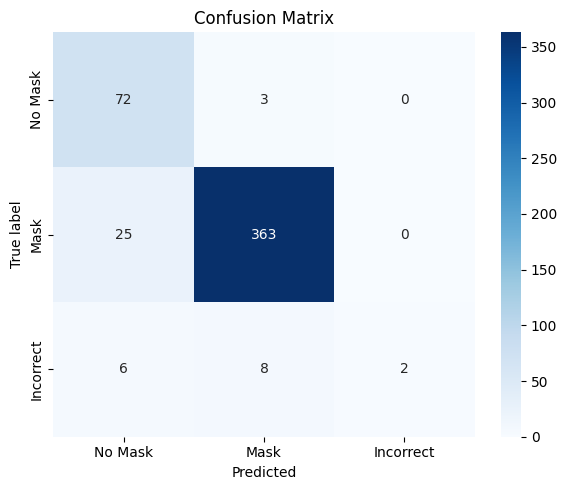


🏆 Best Configuration: ((32, 64, 128, 256), 128, 0.3, 0.0001, 32, 15), Macro F1: 0.7451
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

Evaluation results for Final Model:
Accuracy: 0.9061
F1 Score (macro): 0.7451
F1 Score (weighted): 0.9169

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.79      0.91      0.84        75
        Mask       0.99      0.91      0.95       388
   Incorrect       0.32      0.69      0.44        16

    accuracy                           0.91       479
   macro avg       0.70      0.84      0.75       479
weighted avg       0.94      0.91      0.92       479



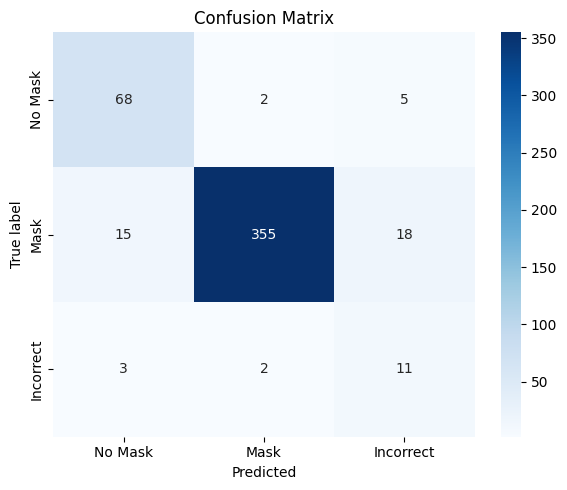

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


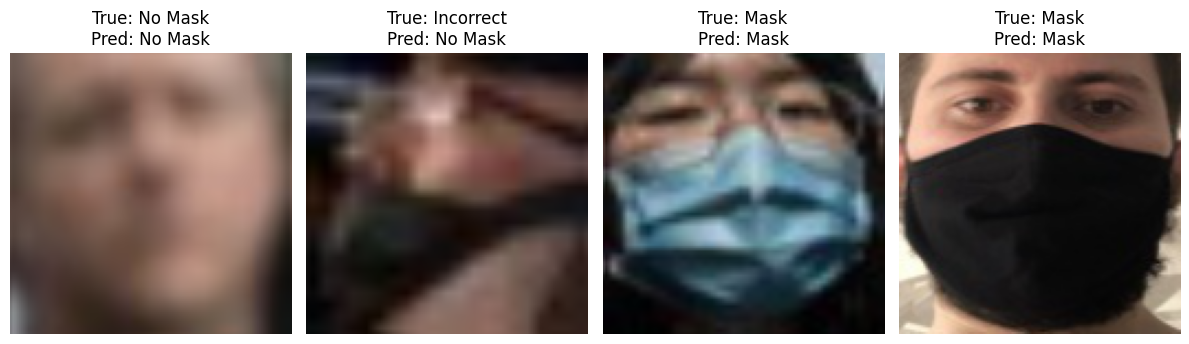

In [28]:
param_grid = [
    ((32, 64, 128), 128, 0.3, 0.001, 32, 15),
    #((32, 64, 128), 256, 0.2, 0.0001, 64, 15),
    ((32, 64, 128, 256), 128, 0.3, 0.0001, 32, 15),
    ((64, 128, 256), 256, 0.2, 0.001, 64, 20),
]

trainer = CNNTrainer()
best_model, best_config = trainer.run_grid_search(X_train, y_train, X_val, y_val, param_grid)
trainer.evaluate_model(best_model, X_val, y_val)
trainer.visualize_predictions(best_model, X_val, y_val)

### these are the best hyperameters

Loaded model parameters:
{'name': 'sequential_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 128, 128, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros'

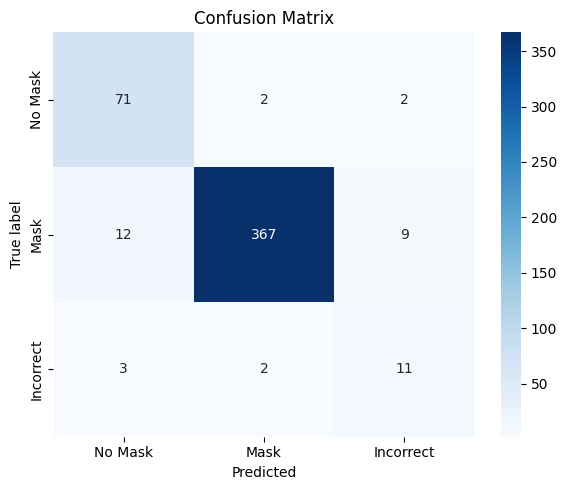

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


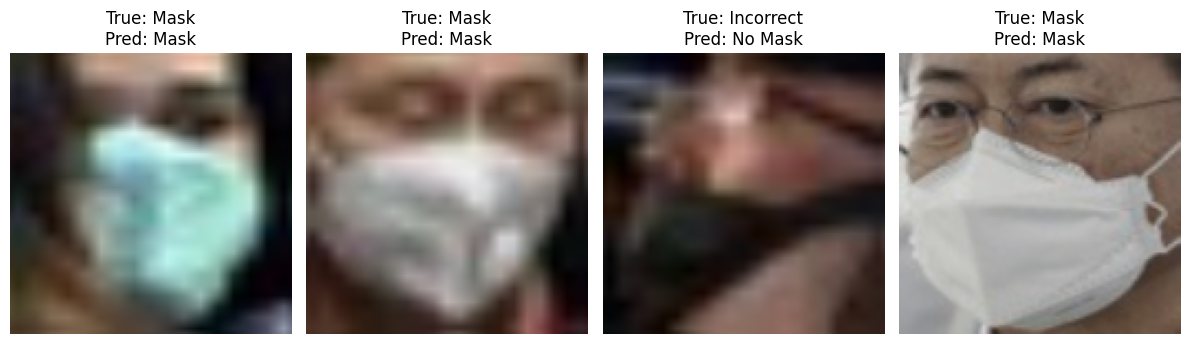

In [38]:

trainer = CNNTrainer()

model = trainer.train_best_model(X_train, y_train, X_val, y_val)

trainer.evaluate_model(model, X_val, y_val)
trainer.visualize_predictions(model, X_val, y_val, n_samples=4)

### testing on test set

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Evaluation results for Final Model:
Accuracy: 0.9127
F1 Score (macro): 0.7478
F1 Score (weighted): 0.9223

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.80      0.96      0.88        51
        Mask       0.99      0.92      0.95       388
   Incorrect       0.32      0.58      0.42        19

    accuracy                           0.91       458
   macro avg       0.70      0.82      0.75       458
weighted avg       0.94      0.91      0.92       458



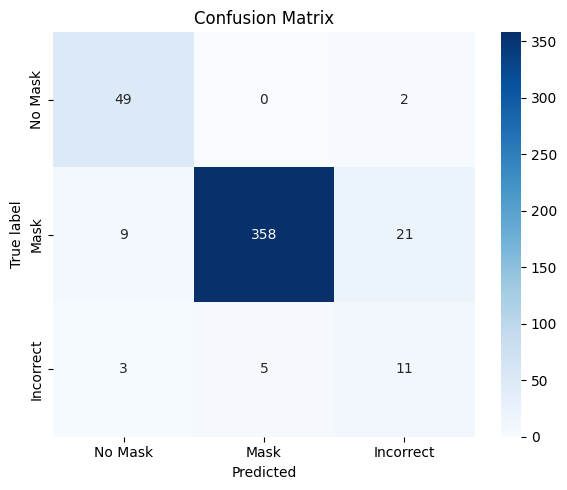

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


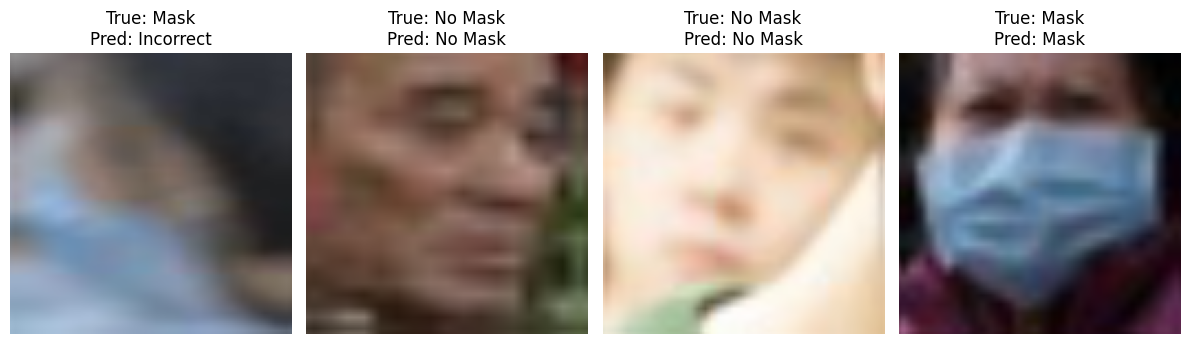

In [39]:
trainer.evaluate_model(model, X_test, y_test)
trainer.visualize_predictions(model, X_test, y_test, n_samples=4)

# MTCNN transfer learning with my model

In [ ]:
from mtcnn.mtcnn import MTCNN
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.api.models import load_model
from skimage.io import imread
from skimage.transform import resize

PROJECT_DIR = os.getcwd()  # If running from notebook in root or Code/ folder
MODEL_PATH = os.path.abspath(os.path.join(PROJECT_DIR, '..', 'Models', 'best_CNN_model.keras'))

# Load the model
model = load_model(MODEL_PATH)

#class names 0,1,2
class_names = ['No Mask', 'Mask', 'Incorrect']

def MaskDetection(path_to_images, image_size=(128, 128), n_samples=4):
    #intialize the face detector 
    detector = MTCNN()
    #list of all images in the file given
    all_images = [f for f in os.listdir(path_to_images) if f.lower().endswith(('.jpg', '.jpeg'))]
    #randomly pull out the (n samples)4 from the spefic folder
    selected = random.sample(all_images, min(n_samples, len(all_images)))

    #wide figure where we show the selected images
    plt.figure(figsize=(15, 5))

    #loop over each image that was selected
    for i, img_name in enumerate(selected):
        #the full path path
        img_path = os.path.join(path_to_images, img_name)
        #load the image, numpy array
        image = imread(img_path)
        #using MTCNN i can detect the faces in the image 
        results = detector.detect_faces(image)
        #create a subplot for the current image
        plt.subplot(1, n_samples, i + 1)
        #show the image 
        plt.imshow(image)
        #get axis to draw the boxes and labels on the boxes
        ax = plt.gca()

        #for images with multiple faces we loop through all those detected in the image
        for face in results:
            #pull the face bounding coordinates
            x, y, w, h = face['box']
            #crop the face from the full image
            face_img = image[y:y+h, x:x+w]
            #skip ones which might cause runtime errors like zero-size or corrupted
            if face_img.shape[0] == 0 or face_img.shape[1] == 0:
                continue
            
            #resize the face image to the input size used by the CNN
            resized_face = resize(face_img, image_size, anti_aliasing=True)
            #predict the mask status using the CNN
            pred = model.predict(np.expand_dims(resized_face, axis=0), verbose=0)[0]
            #determine the index of which class is most likely
            predicted_idx = np.argmax(pred)
            #for confidence scores grab the actual prob for the given prediction
            confidence = pred[predicted_idx]
            #formatted the label, class name and confidence score
            label = f"{class_names[predicted_idx]} ({confidence*100:.1f}%)"

            # Draw bounding box around the face
            rect = plt.Rectangle((x, y), w, h, fill=False, color='lime', linewidth=2)
            ax.add_patch(rect)
            #aboce the bounding box put the label
            ax.text(x, y - 10, label, color='white', fontsize=12, backgroundcolor='black')
        #withouth axis ticks it looks better
        plt.axis('off')
        #title is the image name
        plt.title(f"{img_name}")
    #adjust layout for cleaner look
    plt.tight_layout()
    #display
    plt.show()

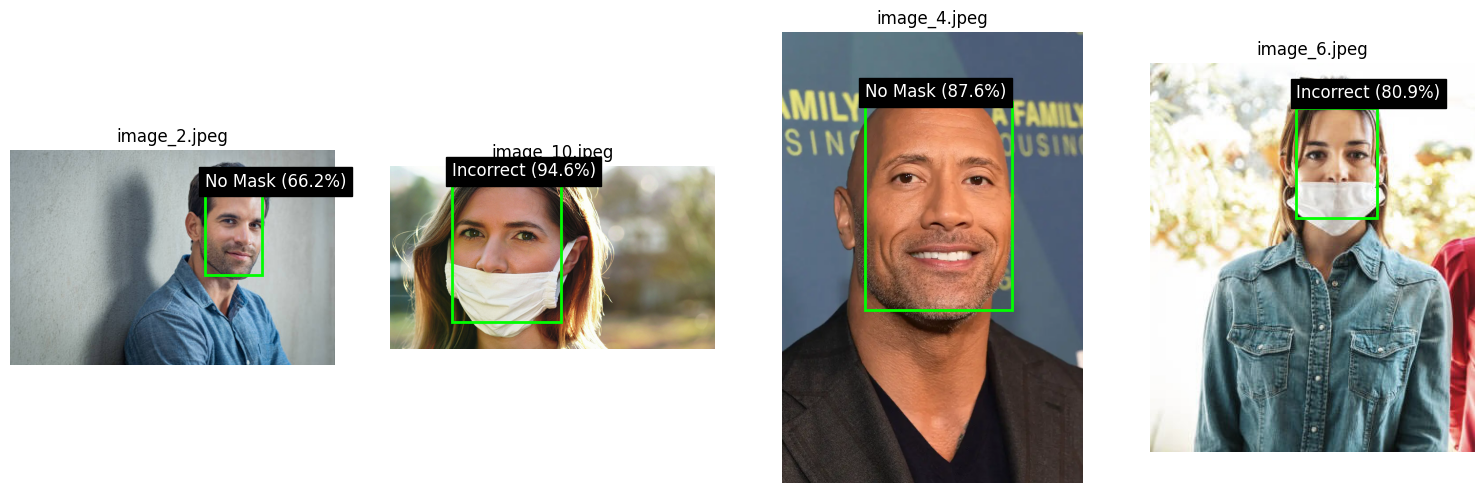

In [55]:


# Get the absolute path to the project root from the notebook
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd()))
# Define path to personal dataset folder
PERSONAL_DATASET_PATH = os.path.join(PROJECT_DIR, '..','personal_dataset', 'images')
MaskDetection(PERSONAL_DATASET_PATH)

# test all models


Testing HOG + SVM Model

Evaluation results for HOG + SVM (Test):
Accuracy: 0.8777
F1 Score (macro): 0.5014
F1 Score (weighted): 0.8463

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.81      0.33      0.47        51
        Mask       0.88      0.99      0.93       388
   Incorrect       1.00      0.05      0.10        19

    accuracy                           0.88       458
   macro avg       0.90      0.46      0.50       458
weighted avg       0.88      0.88      0.85       458



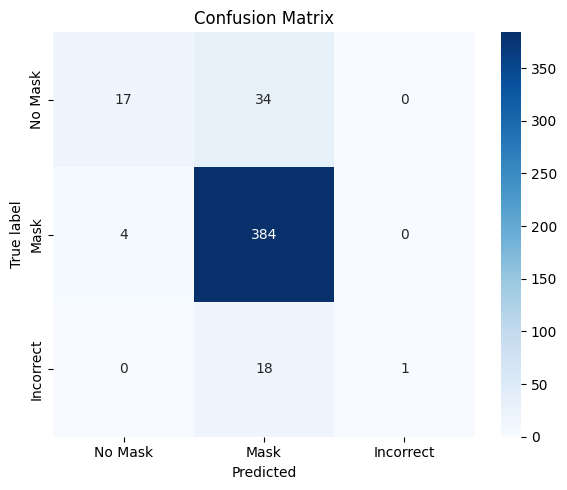


Testing SIFT + MLP Model


Extracting SIFT descriptors: 100%|██████████| 458/458 [00:00<00:00, 458.93it/s]



Evaluation results for SIFT + MLP (Test):
Accuracy: 0.8315
F1 Score (macro): 0.4631
F1 Score (weighted): 0.8224

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.46      0.51      0.48        51
        Mask       0.90      0.91      0.91       387
   Incorrect       0.00      0.00      0.00        19

    accuracy                           0.83       457
   macro avg       0.45      0.47      0.46       457
weighted avg       0.81      0.83      0.82       457



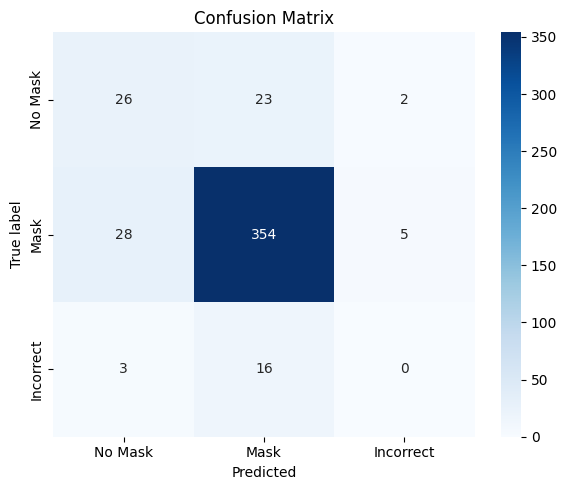


Testing best CNN Model
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Evaluation results for CNN (Test):
Accuracy: 0.9127
F1 Score (macro): 0.7478
F1 Score (weighted): 0.9223

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.80      0.96      0.88        51
        Mask       0.99      0.92      0.95       388
   Incorrect       0.32      0.58      0.42        19

    accuracy                           0.91       458
   macro avg       0.70      0.82      0.75       458
weighted avg       0.94      0.91      0.92       458



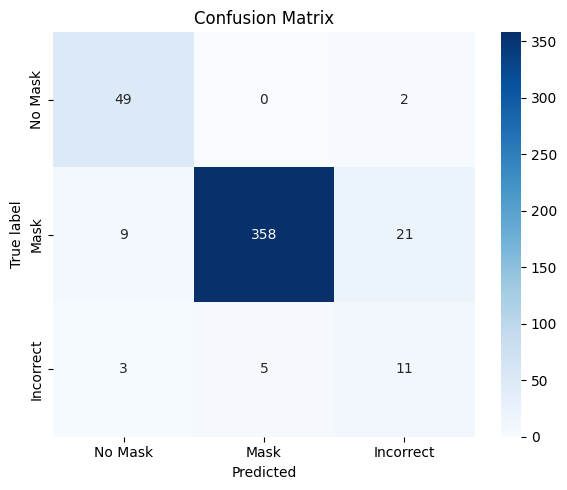

In [53]:
def run_all_saved_models_on_test():
    from evaluator import ModelEvaluator
    import joblib
    import numpy as np
    from keras.api.models import load_model
    import os

    evaluator = ModelEvaluator(class_names=["No Mask", "Mask", "Incorrect"])

    # Setup paths
    NOTEBOOK_DIR = os.getcwd()
    PROJECT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))
    MODEL_DIR = os.path.join(PROJECT_DIR, 'Models')

   
    print("\nTesting HOG + SVM Model")
    from models.hog_svm import extract_hog_features
    hog_model_path = os.path.join(MODEL_DIR, 'hog_svm_model.joblib')
    if os.path.exists(hog_model_path):
        hog_model = joblib.load(hog_model_path)
        X_test_hog = extract_hog_features(X_test)
        y_pred_hog = hog_model.predict(X_test_hog)
        evaluator.evaluate(y_test, y_pred_hog, model_name="HOG + SVM (Test)")
        evaluator.plot_confusion_matrix(y_test, y_pred_hog)
    else:
        print("HOG SVM model not found.")

    print("\nTesting SIFT + MLP Model")
    from models.sift_mlp import extract_sift_descriptors, compute_bovw_histograms
    sift_model_path = os.path.join(MODEL_DIR, 'sift_mlp_model.joblib')
    kmeans_path = os.path.join(MODEL_DIR, 'sift_kmeans.joblib')
    if os.path.exists(sift_model_path) and os.path.exists(kmeans_path):
        sift_model = joblib.load(sift_model_path)
        kmeans_model = joblib.load(kmeans_path)
        descriptors_test, test_indices = extract_sift_descriptors(X_test)
        X_test_bovw = compute_bovw_histograms(descriptors_test, kmeans_model)
        y_test_filtered = y_test[test_indices]
        y_pred_sift = sift_model.predict(X_test_bovw)
        evaluator.evaluate(y_test_filtered, y_pred_sift, model_name="SIFT + MLP (Test)")
        evaluator.plot_confusion_matrix(y_test_filtered, y_pred_sift)
    else:
        print("SIFT model or KMeans model not found.")

    print("\nTesting best CNN Model")
    cnn_model_path = os.path.join(MODEL_DIR, 'best_CNN_model.keras')
    if os.path.exists(cnn_model_path):
        cnn_model = load_model(cnn_model_path)
        y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
        evaluator.evaluate(y_test, y_pred_cnn, model_name="CNN (Test)")
        evaluator.plot_confusion_matrix(y_test, y_pred_cnn)
    else:
        print("CNN model not found.")

run_all_saved_models_on_test()